In [9]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

class FresnelSubstitution:
    """
    Implementation of Fresnel zone-based substitution operation
    Based on the paper's Algorithm 2, 3, and 4
    """
    
    def __init__(self, seed_d=12345, seed_f=67890):
        """
        Initialize with seed values for d and f parameters
        
        Args:
            seed_d: Initial seed for distance parameter
            seed_f: Initial seed for frequency parameter
        """
        self.seed_d = seed_d
        self.seed_f = seed_f
        self.d = seed_d
        self.f = seed_f
        
    def update_df(self, R, c):
        """
        Algorithm 2: Update-df(R, c)
        Updates the d and f parameters based on Fresnel zone radius and pixel value
        
        Args:
            R: Fresnel zone radius (double)
            c: Pixel value (0-255)
            
        Returns:
            Updated f and d values
        """
        # Step 1: Extract long integer from double R
        f = int(R * 1e10) & 0xFFFFFFFFFFFFFFFF  # 64-bit long integer
        
        # Step 2: Update d with pixel influence
        z = c % 32  # Rightmost 6 bits
        shift_amount = c % z if z != 0 else 0
        d = self.d
        d = (c << shift_amount) ^ d
        
        # Steps 3-5: Deep bit manipulation
        d = d ^ (d << 21)
        d = d ^ (d >> 35)
        d = d ^ (d << 4)
        
        # Keep within 64-bit range
        d = d & 0xFFFFFFFFFFFFFFFF
        f = f & 0xFFFFFFFFFFFFFFFF
        
        return f, d
    
    def compute_fresnel_radius(self, d, f):
        """
        Compute Fresnel zone radius using equation (2)
        R = 17.32 × sqrt(d / (4f))
        
        Args:
            d: Distance parameter
            f: Frequency parameter
            
        Returns:
            Fresnel zone radius R
        """
        # Ensure f is not zero
        if f == 0:
            f = 1
        
        # Ensure d is positive
        d = abs(d) if d != 0 else 1
        
        R = 17.32 * np.sqrt(d / (4.0 * f))
        return R
    
    def substitute(self, block):
        """
        Algorithm 3: Substitute operation
        Performs bidirectional substitution on a block of pixels
        
        Args:
            block: 1D numpy array of pixel values
            
        Returns:
            Substituted block
        """
        n = len(block)
        out1 = np.zeros(n, dtype=np.uint8)
        out = np.zeros(n, dtype=np.uint8)
        
        # ==================== Forward pass ====================
        self.d = self.seed_d
        self.f = self.seed_f
        
        for i in range(n):
            b_i = int(block[i])
            
            # Compute R from Fresnel model
            R = self.compute_fresnel_radius(self.d, self.f)
            
            # Extract k from R
            k = int(R * 1e10) % 256
            
            # Substitute pixel
            s_i = k ^ b_i
            out1[i] = s_i
            
            # Update d and f
            self.f, self.d = self.update_df(R, b_i)
        
        # ==================== Backward pass ====================
        self.d = self.seed_d
        self.f = self.seed_f
        
        for i in range(n-1, -1, -1):
            s_i = int(out1[i])
            
            # Compute R from Fresnel model
            R = self.compute_fresnel_radius(self.d, self.f)
            
            # Extract k from R
            k = int(R * 1e10) % 256
            
            # Substitute pixel
            c_i = k ^ s_i
            out[i] = c_i
            
            # Update d and f
            self.f, self.d = self.update_df(R, s_i)
        
        return out
    
    def substitute_inv(self, block):
        """
        Algorithm 4: Substitute-Inv operation
        Inverse substitution to recover original block
        
        Args:
            block: 1D numpy array of substituted pixel values
            
        Returns:
            Original block
        """
        n = len(block)
        out1 = np.zeros(n, dtype=np.uint8)
        B = np.zeros(n, dtype=np.uint8)
        
        # ==================== Backward pass ====================
        self.d = self.seed_d
        self.f = self.seed_f
        
        for i in range(n-1, -1, -1):
            c_i = int(block[i])
            
            # Compute R from Fresnel model
            R = self.compute_fresnel_radius(self.d, self.f)
            
            # Extract k from R
            k = int(R * 1e10) % 256
            
            # Reverse substitute
            s_i = k ^ c_i
            out1[i] = s_i
            
            # Update d and f
            self.f, self.d = self.update_df(R, s_i)
        
        # ==================== Forward pass ====================
        self.d = self.seed_d
        self.f = self.seed_f
        
        for i in range(n):
            s_i = int(out1[i])
            
            # Compute R from Fresnel model
            R = self.compute_fresnel_radius(self.d, self.f)
            
            # Extract k from R
            k = int(R * 1e10) % 256
            
            # Reverse substitute
            b_i = k ^ s_i
            B[i] = b_i
            
            # Update d and f
            self.f, self.d = self.update_df(R, b_i)
        
        return B


def process_image(image_path, seed_d=12345, seed_f=67890):
    """
    Process an image through substitution and inverse substitution
    
    Args:
        image_path: Path to the input image
        seed_d: Seed for distance parameter
        seed_f: Seed for frequency parameter
        
    Returns:
        original_img, substituted_img, recovered_img
    """
    # Load image
    img = Image.open(image_path).convert('L')  # Convert to grayscale
    img_array = np.array(img)
    
    print(f"Original image shape: {img_array.shape}")
    
    # Initialize substitution object
    fs = FresnelSubstitution(seed_d=seed_d, seed_f=seed_f)
    
    # Process image row by row (as per the paper)
    height, width = img_array.shape
    substituted_array = np.zeros_like(img_array)
    
    print("Performing substitution...")
    for i in range(height):
        if i % 50 == 0:
            print(f"  Processing row {i}/{height}")
        row = img_array[i, :]
        substituted_row = fs.substitute(row)
        substituted_array[i, :] = substituted_row
    
    print("Substitution complete!")
    
    # Perform inverse substitution
    recovered_array = np.zeros_like(img_array)
    
    print("\nPerforming inverse substitution...")
    for i in range(height):
        if i % 50 == 0:
            print(f"  Processing row {i}/{height}")
        row = substituted_array[i, :]
        recovered_row = fs.substitute_inv(row)
        recovered_array[i, :] = recovered_row
    
    print("Inverse substitution complete!")
    
    # Verify recovery
    difference = np.sum(np.abs(img_array.astype(int) - recovered_array.astype(int)))
    print(f"\n{'='*60}")
    print(f"Total pixel difference: {difference}")
    print(f"{'='*60}")
    
    if difference == 0:
        print("✓ Perfect recovery! Original image successfully reconstructed.")
    else:
        print("✗ Recovery not perfect. There are differences.")
        max_diff = np.max(np.abs(img_array.astype(int) - recovered_array.astype(int)))
        print(f"  Maximum pixel difference: {max_diff}")
    
    return img_array, substituted_array, recovered_array


class PixelPerturbation:
    """
    Implementation of pixel perturbation operation
    Based on the paper's Algorithm 6, 7, and 8
    """
    
    def __init__(self, r_init, x_init):
        """
        Initialize with logistic map parameters
        
        Args:
            r_init: Logistic map parameter r (should be in range 3.57 to 4)
            x_init: Logistic map initial value x (should be in range 0 to 1)
        """
        self.r = r_init
        self.x = x_init
        self.seed_r = 0
        self.seed_c = 0
        
    def logistic_map(self):
        """
        Generate next value using logistic map
        x_i+1 = r * x_i * (1 - x_i)
        """
        self.x = self.r * self.x * (1 - self.x)
        return self.x
    
    def randomize(self, seed):
        """
        Algorithm 7: Randomize function
        Apply logical shifts and XOR operations
        """
        seed = seed ^ (seed << 21)
        seed = seed ^ (seed >> 35)
        seed = seed ^ (seed << 4)
        return seed & 0xFFFFFFFFFFFFFFFF
    
    def update_position(self, r, c, pixel_value):
        """
        Algorithm 7: Update chaotic position
        Updates r and c based on pixel value
        
        Args:
            r: Row position
            c: Column position
            pixel_value: Current pixel value
            
        Returns:
            Updated (r, c) position
        """
        height = self.height
        width = self.width
        
        # Update seeds with pixel influence
        self.seed_r = self.seed_r ^ (pixel_value // 256)
        self.seed_c = self.seed_c ^ (pixel_value % 256)
        
        # Randomize seeds
        self.seed_r = self.randomize(self.seed_r)
        self.seed_c = self.randomize(self.seed_c)
        
        # Update r and c with modulo to ensure they stay in bounds
        r = (r ^ (self.seed_r % height)) % height
        c = (c ^ (self.seed_c % width)) % width
        
        return r, c
    
    def perturbate_image(self, image):
        """
        Algorithm 6: Image perturbation
        Scrambles pixel positions using chaotic map
        
        Args:
            image: 2D numpy array (height x width)
            
        Returns:
            Perturbed image
        """
        height, width = image.shape
        self.height = height
        self.width = width
        
        # Initialize perturbed image
        image_p = np.full((height, width), -1, dtype=int)
        
        # Generate initial random position
        r = int(self.logistic_map() * height) % height
        c = int(self.logistic_map() * width) % width
        
        # Reset seeds
        self.seed_r = 0
        self.seed_c = 0
        
        for i in range(height):
            for j in range(width):
                pixel_value = int(image[i, j])
                
                # Try to place pixel at (r, c)
                if image_p[r, c] == -1:
                    image_p[r, c] = pixel_value
                else:
                    # Search for empty cell in column c
                    found = False
                    for row in range(height):
                        if image_p[row, c] == -1:
                            image_p[row, c] = pixel_value
                            found = True
                            break
                    
                    # If column c is full, search next columns
                    if not found:
                        for col in range(c + 1, width):
                            for row in range(height):
                                if image_p[row, col] == -1:
                                    image_p[row, col] = pixel_value
                                    found = True
                                    break
                            if found:
                                break
                        
                        # If still not found, search previous columns
                        if not found:
                            for col in range(0, c):
                                for row in range(height):
                                    if image_p[row, col] == -1:
                                        image_p[row, col] = pixel_value
                                        found = True
                                        break
                                if found:
                                    break
                
                # Update position for next pixel
                r, c = self.update_position(r, c, pixel_value)
        
        return image_p.astype(np.uint8)
    
    def perturbate_image_inverse(self, image_p):
        """
        Algorithm 8: Image perturbation inverse
        Restores original pixel positions
        
        Args:
            image_p: Perturbed 2D numpy array (height x width)
            
        Returns:
            Original image
        """
        height, width = image_p.shape
        self.height = height
        self.width = width
        
        # Initialize original image
        image = np.zeros((height, width), dtype=np.uint8)
        
        # Generate initial random position (same as in perturbation)
        # Reset logistic map to initial state
        self.x = self.x_original
        r = int(self.logistic_map() * height) % height
        c = int(self.logistic_map() * width) % width
        
        # Reset seeds
        self.seed_r = 0
        self.seed_c = 0
        
        # Create a boolean mask to track retrieved pixels
        retrieved = np.zeros((height, width), dtype=bool)
        
        for i in range(height):
            for j in range(width):
                # Try to get pixel from (r, c)
                if not retrieved[r, c]:
                    pixel_value = int(image_p[r, c])
                    image[i, j] = pixel_value
                    retrieved[r, c] = True  # Mark as retrieved
                else:
                    # Search for non-empty cell in column c
                    found = False
                    for row in range(height):
                        if not retrieved[row, c]:
                            pixel_value = int(image_p[row, c])
                            image[i, j] = pixel_value
                            retrieved[row, c] = True
                            found = True
                            break
                    
                    # If column c is empty, search next columns
                    if not found:
                        for col in range(c + 1, width):
                            for row in range(height):
                                if not retrieved[row, col]:
                                    pixel_value = int(image_p[row, col])
                                    image[i, j] = pixel_value
                                    retrieved[row, col] = True
                                    found = True
                                    break
                            if found:
                                break
                        
                        # If still not found, search previous columns
                        if not found:
                            for col in range(0, c):
                                for row in range(height):
                                    if not retrieved[row, col]:
                                        pixel_value = int(image_p[row, col])
                                        image[i, j] = pixel_value
                                        retrieved[row, col] = True
                                        found = True
                                        break
                                if found:
                                    break
                
                # Update position for next pixel
                r, c = self.update_position(r, c, int(image[i, j]))
        
        return image


def test_perturbation(image_path, r=3.99, x=0.5):
    """
    Test perturbation and its inverse on an image
    
    Args:
        image_path: Path to the input image
        r: Logistic map parameter (default: 3.99)
        x: Initial value for logistic map (default: 0.5)
        
    Returns:
        original_img, perturbed_img, recovered_img
    """
    # Load image
    img = Image.open(image_path).convert('L')
    img_array = np.array(img)
    
    print(f"Image shape: {img_array.shape}")
    
    # Initialize perturbation
    pp = PixelPerturbation(r_init=r, x_init=x)
    pp.x_original = x  # Store for inverse
    
    print("\nPerforming perturbation...")
    perturbed = pp.perturbate_image(img_array.copy())
    
    print("Performing inverse perturbation...")
    # Reset for inverse
    pp2 = PixelPerturbation(r_init=r, x_init=x)
    pp2.x_original = x
    recovered = pp2.perturbate_image_inverse(perturbed.copy())
    
    # Verify recovery
    difference = np.sum(np.abs(img_array.astype(int) - recovered.astype(int)))
    print(f"\n{'='*60}")
    print(f"Total pixel difference: {difference}")
    print(f"{'='*60}")
    
    if difference == 0:
        print("✓ Perfect recovery! Original image successfully reconstructed.")
    else:
        print("✗ Recovery not perfect. There are differences.")
        print(f"  Maximum pixel difference: {np.max(np.abs(img_array.astype(int) - recovered.astype(int)))}")
    
    return img_array, perturbed, recovered


def visualize_results(original, substituted, recovered):
    """
    Visualize the original, substituted, and recovered images
    """
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Images
    axes[0, 0].imshow(original, cmap='gray')
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(substituted, cmap='gray')
    axes[0, 1].set_title('Substituted Image (Encrypted)')
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(recovered, cmap='gray')
    axes[0, 2].set_title('Recovered Image (Decrypted)')
    axes[0, 2].axis('off')
    
    # Histograms
    axes[1, 0].hist(original.ravel(), bins=256, range=(0, 256), color='blue', alpha=0.7)
    axes[1, 0].set_title('Original Histogram')
    axes[1, 0].set_xlabel('Pixel Value')
    axes[1, 0].set_ylabel('Frequency')
    
    axes[1, 1].hist(substituted.ravel(), bins=256, range=(0, 256), color='red', alpha=0.7)
    axes[1, 1].set_title('Substituted Histogram')
    axes[1, 1].set_xlabel('Pixel Value')
    axes[1, 1].set_ylabel('Frequency')
    
    axes[1, 2].hist(recovered.ravel(), bins=256, range=(0, 256), color='green', alpha=0.7)
    axes[1, 2].set_title('Recovered Histogram')
    axes[1, 2].set_xlabel('Pixel Value')
    axes[1, 2].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate and display statistics
    print("\n" + "="*60)
    print("IMAGE STATISTICS")
    print("="*60)
    print(f"Original  - Mean: {np.mean(original):.2f}, Std: {np.std(original):.2f}")
    print(f"Encrypted - Mean: {np.mean(substituted):.2f}, Std: {np.std(substituted):.2f}")
    print(f"Recovered - Mean: {np.mean(recovered):.2f}, Std: {np.std(recovered):.2f}")
    print("="*60)


def combined_encryption(image_path, seed_d=12345, seed_f=67890, r=3.99, x=0.5):
    """
    Combined encryption: Substitution -> Perturbation -> Inverse Perturbation -> Inverse Substitution
    
    Args:
        image_path: Path to the input image
        seed_d: Seed for distance parameter (substitution)
        seed_f: Seed for frequency parameter (substitution)
        r: Logistic map parameter (perturbation)
        x: Initial value for logistic map (perturbation)
        
    Returns:
        original_img, after_substitution, after_perturbation, after_inv_perturbation, final_recovered
    """
    # Load image
    img = Image.open(image_path).convert('L')
    img_array = np.array(img)
    
    print(f"Original image shape: {img_array.shape}")
    height, width = img_array.shape
    
    # ==================== STEP 1: SUBSTITUTION ====================
    print("\n" + "="*60)
    print("STEP 1: SUBSTITUTION")
    print("="*60)
    
    fs = FresnelSubstitution(seed_d=seed_d, seed_f=seed_f)
    substituted_array = np.zeros_like(img_array)
    
    print("Performing substitution...")
    for i in range(height):
        if i % 50 == 0:
            print(f"  Processing row {i}/{height}")
        row = img_array[i, :]
        substituted_row = fs.substitute(row)
        substituted_array[i, :] = substituted_row
    
    print("✓ Substitution complete!")
    
    # ==================== STEP 2: PERTURBATION ====================
    print("\n" + "="*60)
    print("STEP 2: PERTURBATION")
    print("="*60)
    
    pp = PixelPerturbation(r_init=r, x_init=x)
    pp.x_original = x
    
    print("Performing perturbation on substituted image...")
    perturbed_array = pp.perturbate_image(substituted_array.copy())
    print("✓ Perturbation complete!")
    
    # ==================== STEP 3: INVERSE PERTURBATION ====================
    print("\n" + "="*60)
    print("STEP 3: INVERSE PERTURBATION")
    print("="*60)
    
    pp2 = PixelPerturbation(r_init=r, x_init=x)
    pp2.x_original = x
    
    print("Performing inverse perturbation...")
    inv_perturbed_array = pp2.perturbate_image_inverse(perturbed_array.copy())
    print("✓ Inverse perturbation complete!")
    
    # ==================== STEP 4: INVERSE SUBSTITUTION ====================
    print("\n" + "="*60)
    print("STEP 4: INVERSE SUBSTITUTION")
    print("="*60)
    
    recovered_array = np.zeros_like(img_array)
    
    print("Performing inverse substitution...")
    for i in range(height):
        if i % 50 == 0:
            print(f"  Processing row {i}/{height}")
        row = inv_perturbed_array[i, :]
        recovered_row = fs.substitute_inv(row)
        recovered_array[i, :] = recovered_row
    
    print("✓ Inverse substitution complete!")
    
    # ==================== VERIFICATION ====================
    print("\n" + "="*60)
    print("VERIFICATION")
    print("="*60)
    
    # Check if substitution was reversed correctly
    diff_after_inv_pert = np.sum(np.abs(substituted_array.astype(int) - inv_perturbed_array.astype(int)))
    print(f"Difference after inverse perturbation: {diff_after_inv_pert}")
    if diff_after_inv_pert == 0:
        print("  ✓ Perturbation perfectly reversed!")
    
    # Check if final recovery matches original
    final_difference = np.sum(np.abs(img_array.astype(int) - recovered_array.astype(int)))
    print(f"Final difference (original vs recovered): {final_difference}")
    
    if final_difference == 0:
        print("  ✓ Perfect recovery! Original image successfully reconstructed.")
    else:
        print("  ✗ Recovery not perfect. There are differences.")
        max_diff = np.max(np.abs(img_array.astype(int) - recovered_array.astype(int)))
        print(f"  Maximum pixel difference: {max_diff}")
    
    print("="*60)
    
    return img_array, substituted_array, perturbed_array, inv_perturbed_array, recovered_array


def visualize_combined_encryption(original, substituted, perturbed, inv_perturbed, recovered):
    """
    Visualize all stages of the combined encryption process
    """
    fig, axes = plt.subplots(3, 5, figsize=(20, 12))
    
    # Row 1: Images
    axes[0, 0].imshow(original, cmap='gray')
    axes[0, 0].set_title('1. Original', fontsize=12, fontweight='bold')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(substituted, cmap='gray')
    axes[0, 1].set_title('2. After Substitution', fontsize=12, fontweight='bold')
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(perturbed, cmap='gray')
    axes[0, 2].set_title('3. After Perturbation\n(Fully Encrypted)', fontsize=12, fontweight='bold', color='red')
    axes[0, 2].axis('off')
    
    axes[0, 3].imshow(inv_perturbed, cmap='gray')
    axes[0, 3].set_title('4. After Inv. Perturbation', fontsize=12, fontweight='bold')
    axes[0, 3].axis('off')
    
    axes[0, 4].imshow(recovered, cmap='gray')
    axes[0, 4].set_title('5. Final Recovered', fontsize=12, fontweight='bold', color='green')
    axes[0, 4].axis('off')
    
    # Row 2: Histograms
    axes[1, 0].hist(original.ravel(), bins=256, range=(0, 256), color='blue', alpha=0.7)
    axes[1, 0].set_title('Original Histogram')
    axes[1, 0].set_xlabel('Pixel Value')
    axes[1, 0].set_ylabel('Frequency')
    
    axes[1, 1].hist(substituted.ravel(), bins=256, range=(0, 256), color='orange', alpha=0.7)
    axes[1, 1].set_title('Substituted Histogram')
    axes[1, 1].set_xlabel('Pixel Value')
    axes[1, 1].set_ylabel('Frequency')
    
    axes[1, 2].hist(perturbed.ravel(), bins=256, range=(0, 256), color='red', alpha=0.7)
    axes[1, 2].set_title('Perturbed Histogram')
    axes[1, 2].set_xlabel('Pixel Value')
    axes[1, 2].set_ylabel('Frequency')
    
    axes[1, 3].hist(inv_perturbed.ravel(), bins=256, range=(0, 256), color='orange', alpha=0.7)
    axes[1, 3].set_title('Inv. Perturbed Histogram')
    axes[1, 3].set_xlabel('Pixel Value')
    axes[1, 3].set_ylabel('Frequency')
    
    axes[1, 4].hist(recovered.ravel(), bins=256, range=(0, 256), color='green', alpha=0.7)
    axes[1, 4].set_title('Recovered Histogram')
    axes[1, 4].set_xlabel('Pixel Value')
    axes[1, 4].set_ylabel('Frequency')
    
    # Row 3: Statistics and differences
    images = [original, substituted, perturbed, inv_perturbed, recovered]
    titles = ['Original', 'Substituted', 'Perturbed', 'Inv. Perturbed', 'Recovered']
    
    for idx, (img, title) in enumerate(zip(images, titles)):
        stats_text = f"Mean: {np.mean(img):.2f}\n"
        stats_text += f"Std: {np.std(img):.2f}\n"
        stats_text += f"Min: {np.min(img)}\n"
        stats_text += f"Max: {np.max(img)}"
        
        axes[2, idx].text(0.5, 0.5, stats_text, 
                         ha='center', va='center',
                         fontsize=11, family='monospace',
                         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        axes[2, idx].set_title(f'{title} Stats')
        axes[2, idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed statistics
    print("\n" + "="*60)
    print("DETAILED STATISTICS")
    print("="*60)
    print(f"{'Stage':<20} {'Mean':<10} {'Std':<10} {'Min':<8} {'Max':<8}")
    print("-"*60)
    for img, title in zip(images, titles):
        print(f"{title:<20} {np.mean(img):<10.2f} {np.std(img):<10.2f} {np.min(img):<8} {np.max(img):<8}")
    print("="*60)


# Example usage
print("="*60)
print("COMBINED ENCRYPTION: SUBSTITUTION + PERTURBATION")
print("Implementation from the research paper")
print("="*60)
print("\nUsage:")
print("  # Perform combined encryption and decryption")
print("  original, substituted, perturbed, inv_perturbed, recovered = \\")
print("      combined_encryption('your_image.jpg')")
print("")
print("  # Visualize all stages")
print("  visualize_combined_encryption(original, substituted, perturbed, \\")
print("                                 inv_perturbed, recovered)")
print("="*60)

COMBINED ENCRYPTION: SUBSTITUTION + PERTURBATION
Implementation from the research paper

Usage:
  # Perform combined encryption and decryption
  original, substituted, perturbed, inv_perturbed, recovered = \
      combined_encryption('your_image.jpg')

  # Visualize all stages
  visualize_combined_encryption(original, substituted, perturbed, \
                                 inv_perturbed, recovered)


Original image shape: (183, 276)

STEP 1: SUBSTITUTION
Performing substitution...
  Processing row 0/183
  Processing row 50/183
  Processing row 100/183
  Processing row 150/183
✓ Substitution complete!

STEP 2: PERTURBATION
Performing perturbation on substituted image...
✓ Perturbation complete!

STEP 3: INVERSE PERTURBATION
Performing inverse perturbation...
✓ Inverse perturbation complete!

STEP 4: INVERSE SUBSTITUTION
Performing inverse substitution...
  Processing row 0/183
  Processing row 50/183
  Processing row 100/183
  Processing row 150/183
✓ Inverse substitution complete!

VERIFICATION
Difference after inverse perturbation: 0
  ✓ Perturbation perfectly reversed!
Final difference (original vs recovered): 0
  ✓ Perfect recovery! Original image successfully reconstructed.


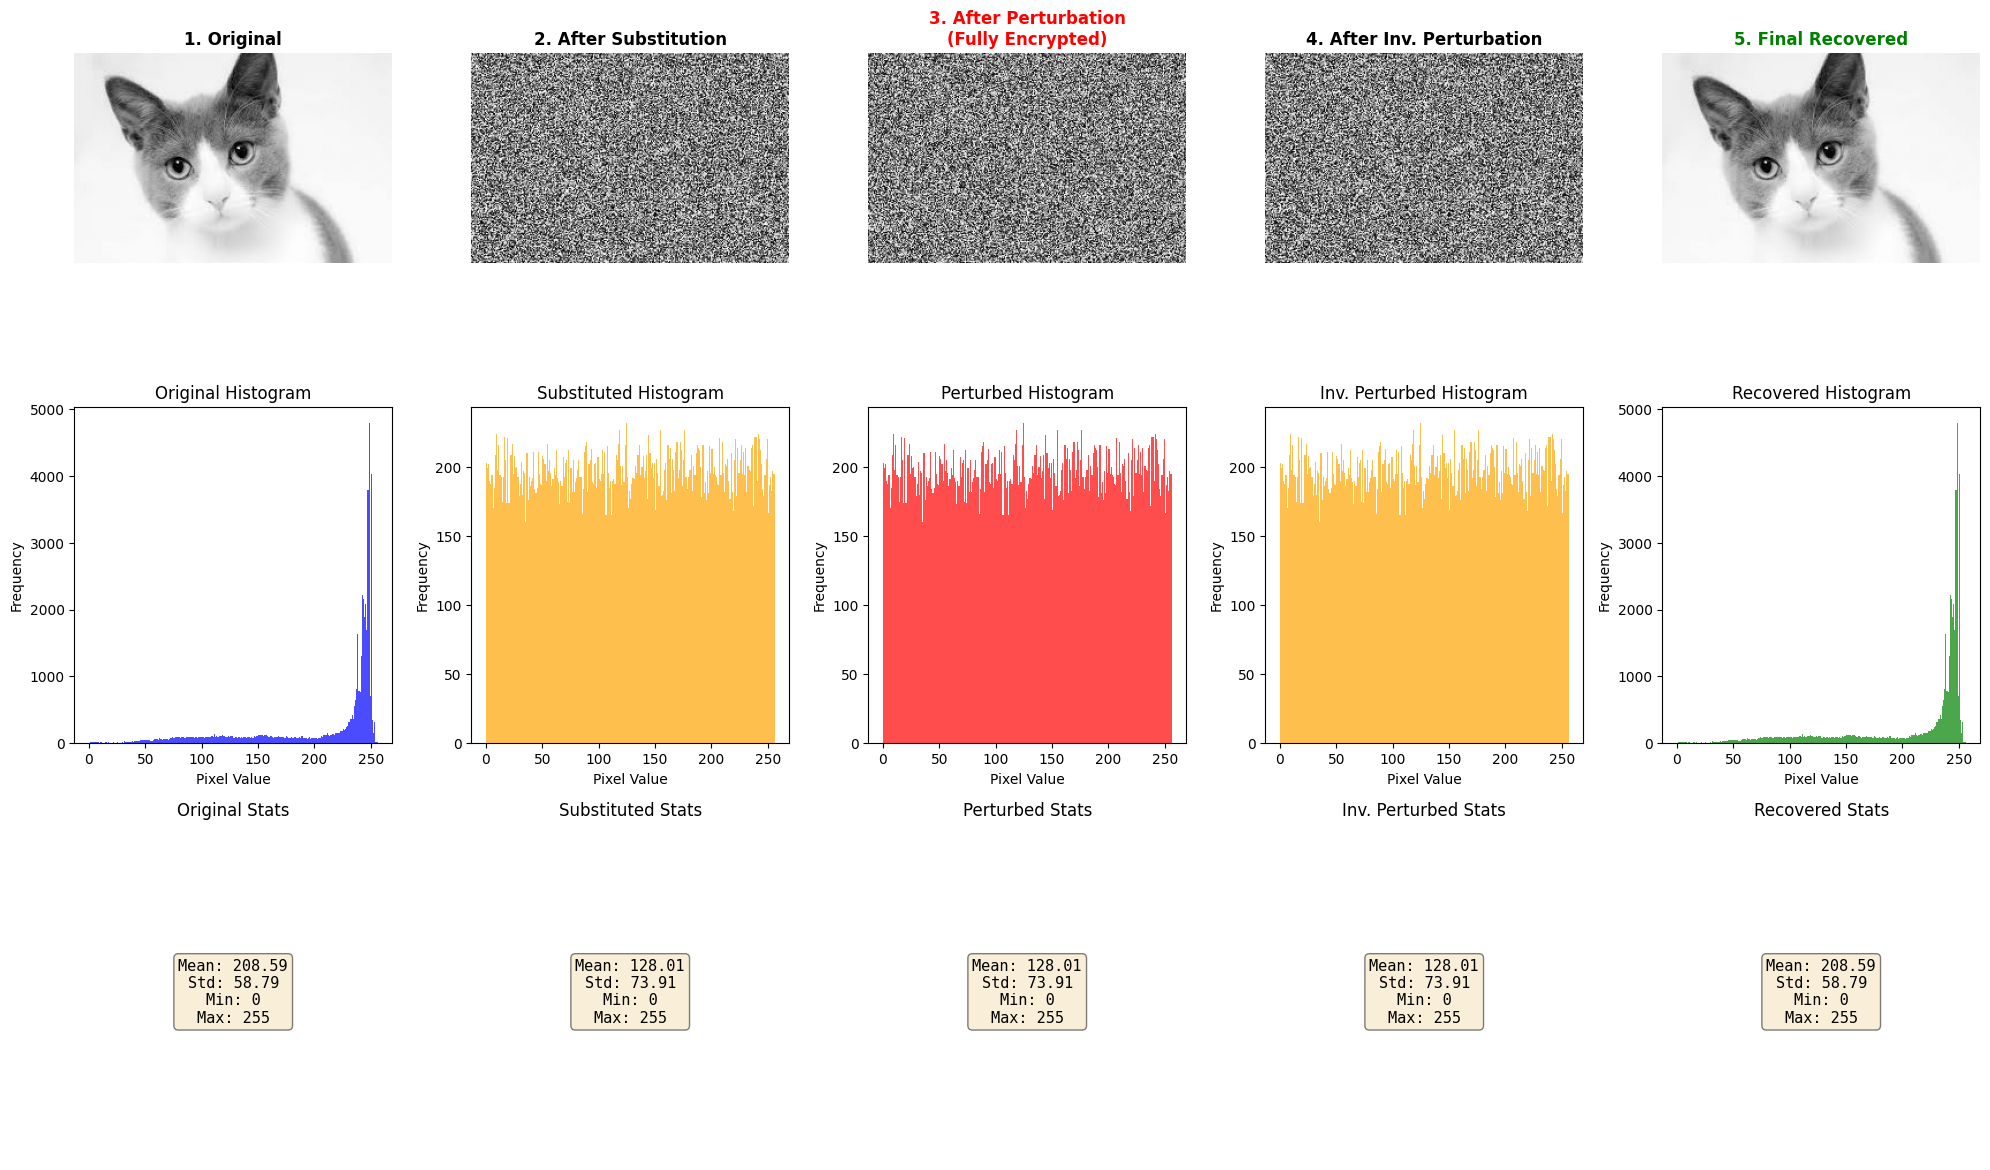


DETAILED STATISTICS
Stage                Mean       Std        Min      Max     
------------------------------------------------------------
Original             208.59     58.79      0        255     
Substituted          128.01     73.91      0        255     
Perturbed            128.01     73.91      0        255     
Inv. Perturbed       128.01     73.91      0        255     
Recovered            208.59     58.79      0        255     


In [10]:
# Perform combined encryption: Substitution -> Perturbation -> Inverse Perturbation -> Inverse Substitution
original, substituted, perturbed, inv_perturbed, recovered = combined_encryption('images.jpg')

# Visualize all 5 stages
visualize_combined_encryption(original, substituted, perturbed, inv_perturbed, recovered)

numpy.ndarray